In [54]:
import json
import os.path as osp
import sys
import time

import joblib
import numpy as np
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.spatial import ConvexHull
import tensorflow as tf

from sandbox.embed2learn.envs.util import colormap_mpl

In [55]:
def rollout(env,
            agent,
            z,
            max_path_length=np.inf,
            animated=False,
            speedup=1,
            always_return_paths=False):

    observations = []
    tasks = []
    latents = []
    latent_infos = []
    actions = []
    rewards = []
    agent_infos = []
    env_infos = []
    env.random_start = False
    # Resets
    o = env.reset()
    agent.reset()

    # Sample embedding network
    # NOTE: it is important to do this _once per rollout_, not once per
    # timestep, since we need correlated noise.
    # t = env.active_task_one_hot
    # z, latent_info = agent.get_latent(t)

    if animated:
        env.render()

    path_length = 0
    while path_length < max_path_length:
        a, agent_info = agent.get_action_from_latent(z, o)
        next_o, r, d, env_info = env.step(a)
        observations.append(agent.observation_space.flatten(o))
        path_length += 1
        if d:
            break
        o = next_o
        if animated:
            env.render()
            timestep = 0.05
            time.sleep(timestep / speedup)
    if animated and not always_return_paths:
        return

    return np.array(observations)

def rollout_given_z(env,
                    agent,
                    z,
                    max_path_length=np.inf,
                    animated=False,
                    speedup=1):
    o = env.reset()
    agent.reset()

    if animated:
        env.render()

    path_length = 0
    observations = []
    while path_length < max_path_length:
        a, agent_info = agent.get_action_from_latent(o, z)
        next_o, r, d, env_info = env.step(a)
        observations.append(agent.observation_space.flatten(o))
        path_length += 1
        if d:
            break
        o = next_o
        if animated:
            env.render()
            time.sleep(0.05 / speedup)

    return np.array(observations)


def get_z_dist(t, policy):
    """ Get the latent distribution for a task """
    onehot = np.zeros(policy.task_space.shape, dtype=np.float32)
    onehot[t] = 1
    _, latent_info = policy.get_latent(onehot)
    return latent_info["mean"], np.exp(latent_info["log_std"])

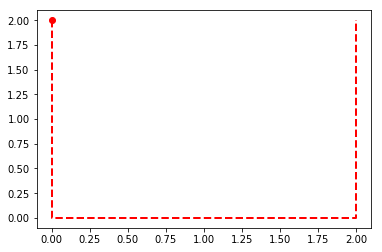

In [56]:
from scipy.spatial import ConvexHull

xs = np.array([0., 0., 2., 2.])
ys = np.array([0., 2., 2., 0.])
corners = np.stack([xs, ys]).T
hull = ConvexHull(corners)
# print(hull.volrolloutume)

plt.plot(corners[hull.vertices,0], corners[hull.vertices,1], 'r--', lw=2)
plt.plot(corners[hull.vertices[0],0], corners[hull.vertices[0],1], 'ro')
plt.show()

In [57]:
EXP_PREFIX = "../../../data/local"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0056"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0064"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0155"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0195"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0243"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0235"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0163"

# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0154"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_13_11_01_54_0019"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_13_11_01_54_0202"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_13_11_01_54_0283"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_13_11_01_54_0200"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0194"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_0127"

# EXP_NAME = "ppo-point-embed-compose/ppo_point_embed_compose_2018_07_25_16_26_51_0001"

# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_10_17_10_38_0001"
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_08_11_14_06_03_0001"

# 12 points
# EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_10_17_44_38_0001"

# EXP_NAME = "ppo-point-embed-random-start-192-polent/ppo_point_embed_random_start_192_polent_2018_08_14_17_01_37_0001"
EXP_NAME = "ppo-point-embed-makeplots/ppo_point_embed_makeplots_2018_08_30_17_23_56_0001"
EXP_NAME = "ppo-point-embed-tanh/ppo_point_embed_tanh_2018_08_30_18_29_22_0001"

EXP_ITR = "200"
EXP = osp.join(EXP_PREFIX, EXP_NAME, "itr_{}.pkl".format(EXP_ITR))
try:
    sess.close()
except NameError:
    pass
sess = tf.InteractiveSession()

# Unpack the snapshot
snapshot = joblib.load(EXP)
env = snapshot["env"]
policy = snapshot["policy"]

# Tasks and goals
num_tasks = policy.task_space.flat_dim
task_envs = env.env._task_envs
goals = np.array([te._goal for te in task_envs])
task_cmap = colormap_mpl(num_tasks)

# Embedding distributions
z_dists = [get_z_dist(t, policy) for t in range(num_tasks)]
z_means = np.array([d[0] for d in z_dists])
z_stds = np.array([d[1] for d in z_dists])

num_latents = z_means[0].shape[0]

print("num_tasks:", num_tasks)
print("num_latents:", num_latents)

# Embedding efficiency
means_area = ConvexHull(z_means).volume
stds_area = np.sum(np.pi * z_stds.prod(axis=1))
print(stds_area/means_area)

{'__args': (<function round_robin at 0x7fe58f6b4158>, <class 'sandbox.embed2learn.envs.point_env.PointEnv'>, [[], [], [], []], [{'goal': (0.0, 3.0), 'never_done': True, 'completion_bonus': 0.0, 'action_scale': 0.1, 'random_start': False}, {'goal': (3.0, 1.8369701987210297e-16), 'never_done': True, 'completion_bonus': 0.0, 'action_scale': 0.1, 'random_start': False}, {'goal': (3.6739403974420594e-16, -3.0), 'never_done': True, 'completion_bonus': 0.0, 'action_scale': 0.1, 'random_start': False}, {'goal': (-3.0, -5.51091059616309e-16), 'never_done': True, 'completion_bonus': 0.0, 'action_scale': 0.1, 'random_start': False}]), '__kwargs': {}, 'params': array([], dtype=float64)}
{'__args': (<sandbox.embed2learn.envs.multi_task_env.MultiTaskEnv object at 0x7fe50efedfd0>,), '__kwargs': {}, 'params': array([], dtype=float64)}
num_tasks: 4
num_latents: 2
0.48392693890735294


[-2.1986846923828125, -2.1988669633865356]
[2.198829710483551, 2.197708308696747]
[[-0.9987009   0.9977084 ]
 [ 0.9988298   0.999113  ]
 [ 0.9984976  -0.9976821 ]
 [-0.99868476 -0.99886703]]


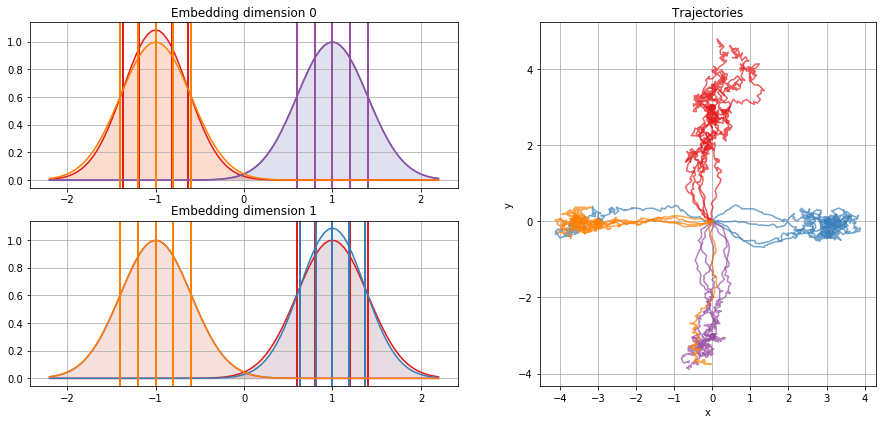

In [58]:
# Combined embedding + corresponding trajectories visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

    
MAX_PATH_LENGTH = 200
SAMPLING_POSITIONS = np.linspace(-1, 1, num=5)


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig = plt.figure(figsize=(13, 6))
# fig.suptitle("Point Embedding")

lr_grid = gridspec.GridSpec(1, 2)
em_grid = gridspec.GridSpecFromSubplotSpec(num_latents, 1, subplot_spec=lr_grid[0])

colormap = lambda x: matplotlib.cm.get_cmap("Set1")(x)
task_cmap = [colormap(task / (num_tasks-1.) * 0.5) for task in range(num_tasks)]

latent_mins, latent_maxs = [], []
for d in range(num_latents):
    lmin, lmax = np.inf, -np.inf
    for task in range(num_tasks):
        mu = z_means[task, d]
        sigma = z_stds[task, d]
        lmin = min(lmin, mu-3*sigma)
        lmax = max(lmax, mu+3*sigma)
    latent_mins.append(lmin)
    latent_maxs.append(lmax)
print(latent_mins)
print(latent_maxs)
print(z_means)

for d in range(num_latents):
    em_ax = plt.Subplot(fig, em_grid[d])
    em_ax.set_title("Embedding dimension %i" % d)
    em_ax.grid()
    for task in range(num_tasks):
        mu = z_means[task, d]
        sigma = z_stds[task, d]
        
        xs = np.linspace(latent_mins[d], latent_maxs[d], 100)
        ys = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (xs - mu)) ** 2))
        
        em_ax.plot(xs, ys, color=task_cmap[task])
        em_ax.fill_between(xs, np.zeros_like(xs), ys, color=task_cmap[task], alpha=.1)
        
        for s in SAMPLING_POSITIONS:
            em_ax.axvline(mu + s * sigma, zorder=2, linewidth=2, color=task_cmap[task])
        
    fig.add_subplot(em_ax)

traj_ax = plt.Subplot(fig, lr_grid[1])
traj_ax.set_title("Trajectories")
traj_ax.grid()
traj_ax.set_aspect("equal")
traj_ax.set_xlabel('x')
traj_ax.set_ylabel('y')
for t in range(num_tasks):
    # Plot goal
    traj_ax.scatter(
        [goals[t, 0]], [goals[t, 1]],
        #s=50,
        color=task_cmap[t],
        zorder=2,
        label="Task {}".format(t + 1))

    # Plot rollouts for linearly interpolated latents
    for i, x in enumerate(SAMPLING_POSITIONS):
        # systematic sampling of latent from embedding distribution
        z = z_means[t] + x * z_stds[t]

        # Run rollout
        obs = rollout(
            task_envs[t],
            policy,
            z,
            max_path_length=MAX_PATH_LENGTH,
            animated=False)

        # Plot rollout
        traj_ax.plot(obs[:, 0], obs[:, 1], alpha=0.7, color=task_cmap[t])

fig.add_subplot(traj_ax)
    
fig.tight_layout()
fig.savefig("point_embed.pdf")

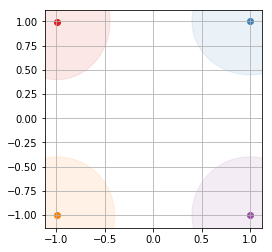

In [59]:
# Embedding visualization
plt.figure()
ax = plt.subplot(111, aspect='equal')
# centers and std circles
for t in range(num_tasks):
    mu = z_means[t, :]
    theta = z_stds[t, :]
    plt.scatter(x=mu[0], y=mu[1], color=task_cmap[t])
    e = Ellipse(tuple(mu), 3*theta[0], 3*theta[1], 0, color=task_cmap[t])
    e.set_alpha(0.1)
    ax.add_artist(e)
plt.grid(True)

/home/eric/anaconda2/envs/garage/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


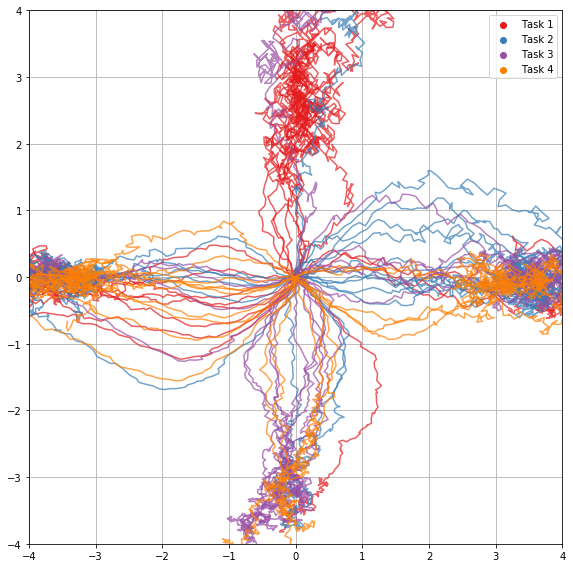

In [60]:
# Rollout visualization
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(8, 8))

MAX_PATH_LENGTH = 200
SAMPLING_POSITIONS = np.linspace(-10, 10, num=20)

for t in range(num_tasks):
    # Plot goal
    plt.scatter(
        [goals[t, 0]], [goals[t, 1]],
        #s=50,
        color=task_cmap[t],
        zorder=2,
        label="Task {}".format(t + 1))

    # Plot rollouts for linearly interpolated latents
    for i, x in enumerate(SAMPLING_POSITIONS):
        # systematic sampling of latent from embedding distribution
        z = z_means[t] + x * z_stds[t]

        # Run rollout
        obs = rollout(
            task_envs[t],
            policy,
            z,
            max_path_length=MAX_PATH_LENGTH,
            animated=False)

        # Plot rollout
        plt.plot(obs[:, 0], obs[:, 1], alpha=0.7, color=task_cmap[t])

plt.grid(True)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.axes().set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

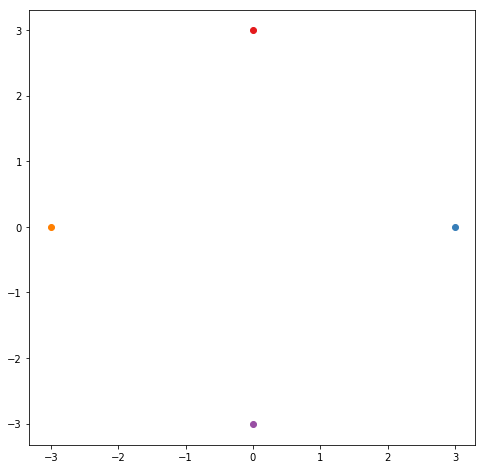

In [61]:
# Rollout visualization
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(8, 8))

MAX_PATH_LENGTH = 50
SAMPLING_POSITIONS = np.linspace(0.0, 1.0, num=20)
# SAMPLING_POSITIONS = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Plot goals
for t in range(num_tasks):
    # Plot goal
    plt.scatter(
        [goals[t, 0]], [goals[t, 1]],
        #s=50,
        color=task_cmap[t],
        zorder=2,
        label="Task {}".format(t + 1))

for t in [0, 1]:
    # Plot rollouts for linearly interpolated latents
    for i, x in enumerate(SAMPLING_POSITIONS):
        # systematic sampling of latent from embedding distribution
        z = (x * z_means[t] + (1.0 - x) * z_means[t+1])
        color = (x * task_cmap[t]) + ((1.0 - x) * task_cmap[t+1])

        # Run rollout
        obs = rollout(
            task_envs[t],
            policy,
            z,
            max_path_length=MAX_PATH_LENGTH,
            animated=False)

        # Plot rollout
        plt.plot(obs[:, 0], obs[:, 1], alpha=0.7, color=color)

plt.grid(True)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.axes().set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
EXP_PREFIX = "../../../data/local/ppo-point-embed"
EXP_ITR = "400"
EXP_NAMES = [
    'ppo_point_embed_2018_07_16_13_34_30_0064',
    'ppo_point_embed_2018_07_13_11_01_54_0123',
    'ppo_point_embed_2018_07_16_13_34_30_0099',
    'ppo_point_embed_2018_07_16_13_34_30_0243',
    'ppo_point_embed_2018_07_16_13_34_30_0207',
    'ppo_point_embed_2018_07_13_11_01_54_0203',
    'ppo_point_embed_2018_07_13_11_01_54_0121',
    'ppo_point_embed_2018_07_13_11_01_54_0204',
    'ppo_point_embed_2018_07_13_11_01_54_0119',
    'ppo_point_embed_2018_07_16_13_34_30_0063',
    'ppo_point_embed_2018_07_16_13_34_30_0062',
    'ppo_point_embed_2018_07_16_13_34_30_0001',
    'ppo_point_embed_2018_07_16_13_34_30_0170',
    'ppo_point_embed_2018_07_13_11_01_54_0362',
    'ppo_point_embed_2018_07_13_11_01_54_0285',
    'ppo_point_embed_2018_07_13_11_01_54_0282',
    'ppo_point_embed_2018_07_13_11_01_54_0280',
    'ppo_point_embed_2018_07_13_11_01_54_0199',
    'ppo_point_embed_2018_07_16_13_34_30_0026',
    'ppo_point_embed_2018_07_16_13_34_30_0134',
    'ppo_point_embed_2018_07_16_13_34_30_0242',
    'ppo_point_embed_2018_07_16_13_34_30_0016',
    'ppo_point_embed_2018_07_16_13_34_30_0006',
    'ppo_point_embed_2018_07_13_11_01_54_0284',
    'ppo_point_embed_2018_07_13_11_01_54_0038',
    'ppo_point_embed_2018_07_16_13_34_30_0098',
    'ppo_point_embed_2018_07_13_11_01_54_0200',
    'ppo_point_embed_2018_07_13_11_01_54_0042',
    'ppo_point_embed_2018_07_16_13_34_30_0239',
    'ppo_point_embed_2018_07_13_11_01_54_0283',
    'ppo_point_embed_2018_07_16_13_34_30_0167',
    'ppo_point_embed_2018_07_13_11_01_54_0192',
    'ppo_point_embed_2018_07_13_11_01_54_0113',
    'ppo_point_embed_2018_07_16_13_34_30_0130',
    'ppo_point_embed_2018_07_16_13_34_30_0095',
    'ppo_point_embed_2018_07_13_11_01_54_0031',
    'ppo_point_embed_2018_07_13_11_01_54_0122',
    'ppo_point_embed_2018_07_13_11_01_54_0194',
    'ppo_point_embed_2018_07_16_13_34_30_0058',
    'ppo_point_embed_2018_07_13_11_01_54_0202',
    'ppo_point_embed_2018_07_16_13_34_30_0131',
    'ppo_point_embed_2018_07_16_13_34_30_0059',
    'ppo_point_embed_2018_07_13_11_01_54_0040',
    'ppo_point_embed_2018_07_13_11_01_54_0032',
    'ppo_point_embed_2018_07_16_13_34_30_0202',
    'ppo_point_embed_2018_07_16_13_34_30_0203',
    'ppo_point_embed_2018_07_13_11_01_54_0028',
    'ppo_point_embed_2018_07_13_11_01_54_0033',
    'ppo_point_embed_2018_07_13_11_01_54_0271',
    'ppo_point_embed_2018_07_13_11_01_54_0029',
]

for n in EXP_NAMES:
    pkl = osp.join(EXP_PREFIX, n, "itr_{}.pkl".format(EXP_ITR))
    var = osp.join(EXP_PREFIX, n, "variant.json".format(EXP_ITR))
    try:
        sess.close()
    except NameError:
        pass
    sess = tf.InteractiveSession()
    
    # Unpack the variant
    v = json.load(open(var))
    pec = v["policy_ent_coeff"]
    eec = v["embedding_ent_coeff"]
    icc = v["inference_ce_coeff"]

    # Unpack the snapshot
    snapshot = joblib.load(pkl)
    env = snapshot["env"]
    policy = snapshot["policy"]

    # Tasks and goals
    num_tasks = policy.task_space.flat_dim
    task_envs = env._wrapped_env.env._task_envs
    goals = np.array([te._goal for te in task_envs])
    task_cmap = colormap_mpl(num_tasks)

    # Embedding distributions
    z_dists = [get_z_dist(t, policy) for t in range(num_tasks)]
    z_means = np.array([d[0] for d in z_dists])
    z_stds = np.array([d[1] for d in z_dists])
    
    # Rollout visualization
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.figure(figsize=(4, 4))

    MAX_PATH_LENGTH = 50
    SAMPLING_POSITIONS = np.linspace(-5, 5, num=20)

    for t in range(num_tasks):
        # Plot goal
        plt.scatter(
            [goals[t, 0]], [goals[t, 1]],
            #s=50,
            color=task_cmap[t],
            zorder=2,
            label="Task {}".format(t + 1))

        # Plot rollouts for linearly interpolated latents
        for i, x in enumerate(SAMPLING_POSITIONS):
            # systematic sampling of latent from embedding distribution
            z = z_means[t] + x * z_stds[t]

            # Run rollout
            obs = rollout(
                task_envs[t],
                policy,
                z,
                max_path_length=MAX_PATH_LENGTH,
                animated=False)

            # Plot rollout
            plt.plot(obs[:, 0], obs[:, 1], alpha=0.7, color=task_cmap[t])

    plt.grid(True)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.axes().set_aspect('equal')
    plt.title("pec: {}, eec: {}, icc: {}".format(pec, eec, icc))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
EXP_NAME = "ppo-point-embed/ppo_point_embed_2018_07_11_14_55_28_0001"

EXP_ITR = "690"
EXP = osp.join(EXP_PREFIX, EXP_NAME, "itr_{}.pkl".format(EXP_ITR))

In [ ]:
EXP